<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks
**Module 10: Time Series in Keras**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 10 Material

* Part 10.1: Time Series Data Encoding for Deep Learning [[Video]](https://www.youtube.com/watch?v=dMUmHsktl04&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_1_timeseries.ipynb)
* Part 10.2: Programming LSTM with Keras and TensorFlow [[Video]](https://www.youtube.com/watch?v=wY0dyFgNCgY&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_2_lstm.ipynb)
* Part 10.3: Text Generation with Keras and TensorFlow [[Video]](https://www.youtube.com/watch?v=6ORnRAz3gnA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_3_text_generation.ipynb)
* Part 10.4: Introduction to Transformers [[Video]](https://www.youtube.com/watch?v=Z7FIdKVQ7kc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_intro_transformers.ipynb)
* **Part 10.5: Transformers for Timeseries** [[Video]](https://www.youtube.com/watch?v=SX67Mni0Or4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
# try:
#     from google.colab import drive
#     drive.mount('/content/drive', force_remount=True)
#     COLAB = True
#     print("Note: using Google CoLab")
#     %tensorflow_version 2.x
# except:
#     print("Note: not using Google CoLab")
#     COLAB = False

# Part 10.5: Programming Transformers with Keras

This section shows an example of a transformer encoder to predict sunspots.  You can find the data files needed for this example at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

The following code loads the sunspot file:


In [2]:
import pandas as pd
import numpy as np
import os

# names = ['year', 'month', 'day', 'dec_year', 'u' ,
#          'x', 'obs_num', 'extra']
# df = pd.read_csv(
#     "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
#     sep=';',header=None,names=names,
#     na_values=['-1'], index_col=False)

names = ['year', 'u' , 'x', 'obs_num']

df = pd.read_csv("data.csv",sep=',', header=0, names=names,index_col=False)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.bfill(inplace=True)
df.ffill(inplace=True) #for obs num


print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

print(df.shape)

Starting file:
       year         u         x  obs_num
0  0.000000  0.250000  0.125000      1.0
1  0.000002  0.250000  0.125002      1.0
2  0.000004  0.250001  0.125004      1.0
3  0.000006  0.250001  0.125006      1.0
4  0.000008  0.250001  0.125009      1.0
5  0.000010  0.250001  0.125011      1.0
6  0.000012  0.250002  0.125013      1.0
7  0.000014  0.250002  0.125015      1.0
8  0.000016  0.250002  0.125017      1.0
9  0.000018  0.250002  0.125019      1.0
Ending file:
             year         u         x  obs_num
1499990  0.999982  1.999964  2.333243      3.0
1499991  0.999984  1.999968  2.333253      3.0
1499992  0.999986  1.999972  2.333263      3.0
1499993  0.999988  1.999976  2.333273      3.0
1499994  0.999990  1.999980  2.333283      3.0
1499995  0.999992  1.999984  2.333293      3.0
1499996  0.999994  1.999988  2.333303      3.0
1499997  0.999996  1.999992  2.333313      3.0
1499998  0.999998  1.999996  2.333323      3.0
1499999  1.000000  2.000000  2.333333      3.0
(150

As you can see, there is quite a bit of missing data near the end of the file.  We want to find the starting index where the missing data no longer occurs.  This technique is somewhat sloppy; it would be better to find a use for the data between missing values.  However, the point of this example is to show how to use a transformer encoder with a somewhat simple time series.

In [3]:
# # Find the last zero and move one beyond
# start_id = max(df[df['obs_num'] == 0].index.tolist())+1
# print(start_id)
# df = df[start_id:] # Trim the rows that have missing observations

Divide into training and test/validation sets.

In [4]:
df['u'] = df['u'].astype(float)
df12 = df[df['obs_num']<3.0]

df_train = df12[df12['year']<0.7]
df_test = df12[df12['year']>=0.7]

spots_train_u = df_train['u'].tolist()
spots_train_x = df_train['x'].tolist()
spots_test_u = df_test['u'].tolist()
spots_test_x = df_test['x'].tolist()

print("Training set has {} observations.".format(len(spots_train_u)))
print("Test set has {} observations.".format(len(spots_test_u)))
# print(spots_train)

Training set has 700000 observations.
Test set has 300000 observations.


In [5]:

df1 = df[df['obs_num']==1.0]
df2 = df[df['obs_num']==2.0]

df_test1 = df1[df1['year']>=0.7]
df_test2 = df2[df2['year']>=0.7]

spots_test1_u = df_test1['u'].tolist()
spots_test1_x = df_test1['x'].tolist()
spots_test2_x = df_test2['x'].tolist()
spots_test2_u = df_test2['u'].tolist()

print("Test set 1 has {} observations.".format(len(spots_test1_u)))
print("Test set 2 has {} observations.".format(len(spots_test2_u)))

Test set 1 has 150000 observations.
Test set 2 has 150000 observations.


The **to_sequences** function takes linear time series data into an **x** and **y** where **x** is all possible sequences of seq_size. After each **x** sequence, this function places the next value into the **y** variable. These **x** and **y** data can train a time-series neural network.

In [6]:
import numpy as np

def to_sequences(seq_size, obs_x, obs_u):

    x = []
    y = []
    for i in range((len(obs_x))-SEQUENCE_SIZE):
        window = obs_x[i:(i+SEQUENCE_SIZE)] #use values of x to predict u
        after_window = obs_u[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)

SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train_x, spots_train_u )
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test_x, spots_test_u)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (699990, 10, 1)
Shape of test set: (299990, 10, 1)


In [7]:

x_test1, y_test1 = to_sequences(SEQUENCE_SIZE,spots_test1_x, spots_test1_u)
print("Shape of y1 test set: {}".format(y_test1.shape))

x_test2, y_test2 = to_sequences(SEQUENCE_SIZE,spots_test2_x, spots_test2_u)
print("Shape of y2 test set: {}".format(y_test2.shape))

Shape of y1 test set: (149990,)
Shape of y2 test set: (149990,)


We can view the results of the **to_sequences** encoding of the sunspot data.

In [8]:

# print('func 1',x_train[0])
# print('func 2',x_train[1])

In [9]:
#!pip install tensorflow

Next, we create the transformer_encoder; I obtained this function from a [Keras example](https://keras.io/examples/timeseries/timeseries_transformer_classification/). This layer includes residual connections, layer normalization, and dropout. This resulting layer can be stacked multiple times. We implement the projection layers with the Keras Conv1D.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    print('x',x.shape,x)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    #x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

The following function is provided to build the model, including the attention layer.

In [17]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.4,
    mlp_dropout=0.25,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    print(x.shape, x)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        #x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

We are now ready to build and train the model.

In [18]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0,
    dropout=0,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=1,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

x (None, 10, 1) <KerasTensor shape=(None, 10, 1), dtype=float32, sparse=False, name=keras_tensor_33>
x (None, 10, 1) <KerasTensor shape=(None, 10, 1), dtype=float32, sparse=False, name=keras_tensor_40>
x (None, 10, 1) <KerasTensor shape=(None, 10, 1), dtype=float32, sparse=False, name=keras_tensor_47>
x (None, 10, 1) <KerasTensor shape=(None, 10, 1), dtype=float32, sparse=False, name=keras_tensor_54>
(None, 10, 1) <KerasTensor shape=(None, 10, 1), dtype=float32, sparse=False, name=keras_tensor_60>
 721/8750 ━━━━━━━━━━━━━━━━━━━━ 10:05 75ms/step - loss: 5588.9722

KeyboardInterrupt: 

Finally, we evaluate the model with RMSE.

In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

9375/9375 ━━━━━━━━━━━━━━━━━━━━ 185s 20ms/step
Score (RMSE): 1.4952773067094058


In [ ]:
preds = []
rmse = []
for x,y in [[x_test1, y_test1],[x_test2, y_test2]]:
    pred = model.predict(x)
    score = np.sqrt(metrics.mean_squared_error(pred,y))
    print("Score (RMSE): {}".format(score))

    preds.append(pred)
    rmse.append(score)

print('Prediction shape: ', len(preds))

4688/4688 ━━━━━━━━━━━━━━━━━━━━ 94s 20ms/step
Score (RMSE): 1.3102941629592635
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 96s 20ms/step
Score (RMSE): 1.6597973670932604
Prediction shape:  2


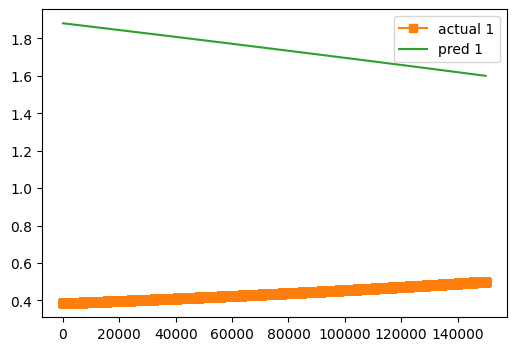

In [ ]:
import matplotlib.pyplot as plt
func = 0
plt.figure(figsize=(6, 4))
plt.plot(y_test1, 's-',color='C1', label=f'actual {1}')
plt.plot(preds[func], '-',color='C2', label=f'pred {1}')

plt.legend()

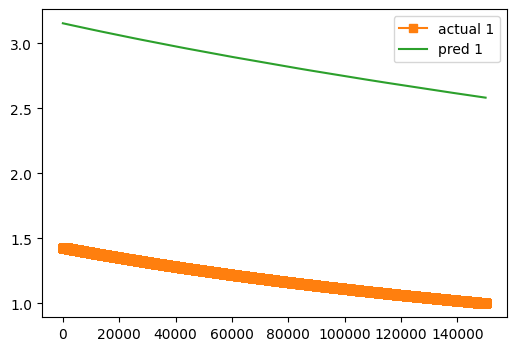

In [ ]:
import matplotlib.pyplot as plt
func = 1
plt.figure(figsize=(6, 4))
plt.plot(y_test2, 's-',color='C1', label=f'actual {1}')
plt.plot(preds[func], '-',color='C2', label=f'pred {1}')

plt.legend()